In [1]:
# --- Setup & Imports ----------------------------------------------------------
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
import pickle
from scipy import stats
import scipy.io as sio
from scipy.io import loadmat
import pandas as pd
from scipy.stats import pearsonr, linregress
# Point Python to your src/ folder
sys.path.append(os.path.abspath("../src"))

from preprocessing import *
from NPI import *
from group_analysis import *
from connectivity import *


# Import Connectome and Atlas data

In [3]:
# Define base path (adjust depending on where you run the notebook)
base_dir = os.path.abspath('..')  # go one level up from /notebooks
data_dir = os.path.join(base_dir, 'data', 'connectome')

# Load .mat files
#path_AAL = os.path.join(data_dir, 'AAL_labels_complete_symmetric.mat')
path_PET = os.path.join(data_dir, 'Hansen_NM_PET_Maps.mat')
path_RSN = os.path.join(data_dir, 'RSNsAAL_non-symmetric.mat')
path_SC  = os.path.join(data_dir, 'SC.mat')

#AAL_labels = loadmat(path_AAL)
PET_maps   = loadmat(path_PET)
RSNsAAL    = loadmat(path_RSN)
SC_mat         = loadmat(path_SC)

# Resting State Networks
RSNs_labels = ['Visual', 'Somatomotor', 'Dorsal Attn', 'Sal-VentAttn', 'Limbic', 'Control', 'Default']

RSN_probs=RSNsAAL['Yeo_AAL']
RSN_probs=RSN_probs.astype(float)
for i in range(7):
    RSN_probs[i]=RSN_probs[i]/np.max(RSN_probs[i])
    
# 1. Assign each ROI to the RSN with maximum probability (0–6)
RSNs_max_prob = np.argmax(RSN_probs, axis=0)  # shape (90,)
# 2. Reorder ROIs so that all Left (L) come before Right (R) as in [L0, L1, ..., LN, RN, ...,R1, R0]
L_ids = np.arange(0, 90, 2)
R_ids = np.arange(1, 90, 2)
RSNs = np.concatenate([RSNs_max_prob[L_ids], RSNs_max_prob[R_ids][::-1]])

# labels to sort by RSNs
order=np.argsort(RSNs, kind='stable')
order_mat=np.ix_(order,order)
RSN_ordered = RSNs[order] 

# Load the CSV
df_aal = pd.read_csv(data_dir+'/aal.csv', header=None)

ROIs_labels = df_aal.iloc[:, 0].astype(str).str.strip().tolist()

# Structural Connectivity
SC=SC_mat['C']

# Extract labels and flatten to clean strings
labels = [str(l[0]) for l in PET_maps['Maps_Labels'].squeeze()]
maps = PET_maps['NM_PET_Maps'][:, :90]  # shape (19, 90)
maps=maps[:,np.hstack((L_ids,R_ids[::-1]))]
# Create dict: {label: (90,) array}
PET_dict = {label: maps[i, :] for i, label in enumerate(labels)}

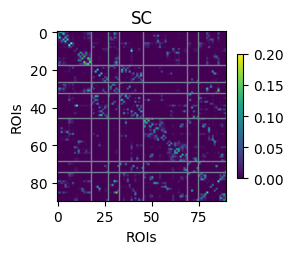

In [4]:
plt.figure(figsize=(3,3,))
plt.imshow(SC[order_mat].T)
plt.colorbar(shrink=0.5)
plt.title('SC')
plt.xlabel('ROIs')
plt.ylabel('ROIs')

# --- compute boundaries between networks ---
boundaries = np.where(np.diff(RSN_ordered) != 0)[0] + 1
# --- draw separator lines ---
for b in boundaries:
    plt.axhline(b - 0.5, color='slategray', lw=1)
    plt.axvline(b - 0.5, color='slategray', lw=1)
    
plt.tight_layout()
plt.show()

# Import fMRI data

In [5]:
# build the path relative to your notebook
file_path = os.path.join("../data/fmri/ts_coma24_AAL_symm.mat")
mat_data = sio.loadmat(file_path)

ts_controls = mat_data["timeseries_CNT24_symm"]
ts_mcs      = mat_data["timeseries_MCS24_symm"]
ts_uws      = mat_data["timeseries_UWS24_symm"]

# Unpack each group
controls = unpack_group(ts_controls)
mcs      = unpack_group(ts_mcs)
uws      = unpack_group(ts_uws)

# --- add preprocessing (k=2 Butterworth 0.01–0.08 Hz) plus zscore ---
controls = preprocess_groups(controls)
mcs      = preprocess_groups(mcs)
uws      = preprocess_groups(uws)

In [6]:
T=mcs[0].shape[0]   # time points
N=mcs[0].shape[1]   # number of regions
tri_N=np.triu_indices(N,1)
tri_T=np.triu_indices(T,1)

groups = {"CNT": controls, "MCS": mcs, "UWS": uws}
groups_id = list(groups.keys())

cols = {"CNT": "#DCA258", "MCS": "#AA7798", "UWS": "#524F88"}
markers = {"CNT": "o", "MCS": "s", "UWS": "^"}

# Personalized ANN

In [7]:
# -----------------------
# Train ANN for each participant
# -----------------------
# Assuming `groups` is like:
# groups = {"CNT": [np.ndarray(T,N), ...], "MCS": [...], "UWS": [...]}

S=3

models_by_group = train_models_for_groups(
    groups,
    steps=S,
    num_epochs=100,
    lr=1e-3,
    l2=5e-5,
    save_dir=None  # or None to skip saving
)

# Quick summary print
for g, lst in models_by_group.items():
    print(f"{g}: {len(lst)} trained models")
    if lst:
        h = lst[0]["history"]
        print(f"  example final losses — train {h['train_loss'][-1]:.6f}, test {h['test_loss'][-1]:.6f}")


=== Group: CNT — 13 subjects ===
[OK]  CNT[0] — T=192, N=90, W=189 | final train=0.049060, test=0.509280 (3.6s)
[OK]  CNT[1] — T=192, N=90, W=189 | final train=0.040625, test=0.455340 (1.2s)
[OK]  CNT[2] — T=192, N=90, W=189 | final train=0.059213, test=0.455100 (1.2s)
[OK]  CNT[3] — T=192, N=90, W=189 | final train=0.037745, test=0.592910 (1.2s)
[OK]  CNT[4] — T=192, N=90, W=189 | final train=0.043023, test=0.626504 (1.6s)
[OK]  CNT[5] — T=192, N=90, W=189 | final train=0.048254, test=0.499079 (1.3s)
[OK]  CNT[6] — T=192, N=90, W=189 | final train=0.040429, test=0.636652 (1.2s)
[OK]  CNT[7] — T=192, N=90, W=189 | final train=0.047024, test=0.752829 (1.4s)
[OK]  CNT[8] — T=192, N=90, W=189 | final train=0.057819, test=0.489044 (1.4s)
[OK]  CNT[9] — T=192, N=90, W=189 | final train=0.045088, test=0.572377 (1.4s)
[OK]  CNT[10] — T=192, N=90, W=189 | final train=0.044402, test=0.402449 (1.4s)
[OK]  CNT[11] — T=192, N=90, W=189 | final train=0.050215, test=0.523997 (1.4s)
[OK]  CNT[12] — 

# Effective Connectivity at each time

In [8]:
# ========================================================================
# For each group (g) and subject (isu):
# This block computes:
#
#   - ECts_sim[g][isu] → the *time-resolved EC(t)* estimates, i.e., EC
#     computed for each time window or initial condition separately.
#
# The underlying rationale:
# For each model (subject), the ANN simulates brain dynamics given an
# empirical time series Z (T × N, time × regions). By perturbing each
# region (target) at each initial condition and comparing to the
# unperturbed trajectory, we estimate the directed influence each node
# exerts on others (effective connectivity).
# ========================================================================

ECts = {}
pert_strength = 0.1  # strength of simulated perturbation

for g in groups_id:
    print(g)
    ECts[g] = {}

    for isu in range(len(groups[g])):
        # ---------------------------------------------------------------
        # 1. Pull the subject's simulated or empirical time series
        #    Z has shape (T, N): T time points, N brain regions
        # ---------------------------------------------------------------
        Z = groups[g][isu][:T, :]

        # ---------------------------------------------------------------
        # 2. Prepare data windows for the EC model
        #    multi2one creates input-output pairs:
        #      X: (W, S*N) → concatenated S past states (inputs)
        #      Y: (W, N)   → next state to predict (targets)
        # ---------------------------------------------------------------
        X, Y = multi2one(Z, steps=S)

        # ---------------------------------------------------------------
        # 3. Compute time-resolved EC(t)
        #    model_ECt returns EC estimates for each window or initial
        #    condition (M time points × N × N)
        # ---------------------------------------------------------------
        ECts[g][isu] = model_ECt(
            models_by_group[g][isu]['model'],
            input_X=X, target_Y=Y,
            pert_strength=pert_strength
        )  # → (M, N, N)

CNT
MCS
UWS


# Jacobian J at each time

In [9]:
# ========================================================================
# For each group (g) and subject (isu):
# This block computes:
#
#   - Jts_sim[g][isu] → the *time-resolved J(t)* estimates, i.e., J
#     computed for each time window or initial condition separately.

# The underlying rationale:
# For each model (subject), the ANN simulates brain dynamics given an
# empirical time series Z (T × N, time × regions). By extracting the Jacobian
# at each initial condition we evaluate the local linear sensitivity
# i.e., how small perturbations in the current state are transformed into changes in the next state.
# ========================================================================

Jts = {}
pert_strength = 0.1  # strength of simulated perturbation

for g in groups_id:
    print(g)
    Jts[g] = {}

    for isu in range(len(groups[g])):

        Z = groups[g][isu][:T, :] #(T, N)

        # ---------------------------------------------------------------
        # 2. Prepare data windows
        #      X: (W, S*N) → concatenated S past states (inputs)
        #      Y: (W, N)   → next state to predict (targets)
        # ---------------------------------------------------------------
        X, Y = multi2one(Z, steps=S)

        # ---------------------------------------------------------------
        # 3. Compute time-resolved EC(t)
        Jts[g][isu] = model_Jacobian_timewise(
            models_by_group[g][isu]['model'],
            input_X=X, steps=S
        )  # → (M, N, N)

CNT
MCS
UWS


# Bifocal Effective Connectivity (l2 dist) at each time

In [10]:
# ======================================================================
# For each group (g) and subject (isu):
# Compute the **Bifocal Effective Connectivity (BEC)**.
#
# Conceptually:
#   - BEC measures how pairs of simultaneously stimulated regions
#     (i,j) jointly affect the global brain state.
#   - Each matrix element BEC[i, j] represents the *distance in state
#     space* between the perturbed and unperturbed trajectories,
#     when regions i and j are jointly stimulated.
#   - The distance metric (e.g., 'l2', 'cosine_dist', or 'angle')
#     quantifies how different the overall system response is.
#   - Since we stimulate 2 sites and we want to preserve the total energy 
#     of the stimulation, we divide the perturbation strength by sqrt(2)
# Outputs:
#   BECts_sim[g][isu] → (M, E) time-resolved BEC(t)
#
# Steps:
#   1. Obtain empirical/simulated state sequences (Z)
#   2. Prepare model input/output pairs (X, Y)
#   3. Compute BEC(t) across time windows using model_BECt()
# ======================================================================

BECts_l2 = {}
pert_strength = 0.1/np.sqrt(2)

for g in groups_id:
    print(g)
    BECts_l2[g] = {}

    for isu in range(len(groups[g])):

        Z = groups[g][isu][:T, :] #(T, N)

        # ---------------------------------------------------------------
        # 2. Create input-output window
        #    X: concatenated S past states, shape (W, S*N)
        #    Y: next state targets, shape (W, N)
        # ---------------------------------------------------------------
        X, Y = multi2one(Z, steps=S)

        # ---------------------------------------------------------------
        # 3. Compute Bifocal Effective Connectivity
        # ---------------------------------------------------------------
        BECts_l2[g][isu] = model_BECt(
            models_by_group[g][isu]['model'],
            input_X=X,
            target_Y=Y,
            pert_strength=pert_strength,
            metric='l2'
        )  # → (M, N, N)

CNT
MCS
UWS


In [11]:
BECts_cos = {}
pert_strength = 0.1/np.sqrt(2)

for g in groups_id:
    print(g)
    BECts_cos[g] = {}
    for isu in range(len(groups[g])):
        Z = groups[g][isu][:T, :]
        
        X, Y = multi2one(Z, steps=S)
        
        BECts_cos[g][isu] = model_BECt(
            models_by_group[g][isu]['model'],
            input_X=X,
            target_Y=Y,
            pert_strength=pert_strength,
            metric='cosine_dist'
        )  # → (M, N, N)

CNT
MCS
UWS


# Baseline and Effects

In [12]:
# ========================================================================
# For each group (g) and subject (isu):
# This block computes and stores:
#   - baseline_t (M,N)         = x(t)
#   - baseline_tp1 (M,N)       = x(t+1) = f(x(t))
#   - effect_nl_tp1 (M,N,N)    = f(x(t) + δ_i)      → absolute nonlinear next state
#   - effect_l_tp1 (M,N,N)     = x(t+1) + J_t δ_i   → absolute linear next state
#
# ========================================================================

Baseline_t = {}
Baseline_tp1 = {}
Effect_nl_tp1 = {}
Effect_l_tp1 = {}

pert_strength = 0.1  # perturbation amplitude

for g in groups_id:
    print(f"Processing group {g} ...")
    Baseline_t[g] = {}
    Baseline_tp1[g] = {}
    Effect_nl_tp1[g] = {}
    Effect_l_tp1[g] = {}

    for isu in range(len(groups[g])):
        print(f"  Subject {isu+1}/{len(groups[g])}")

        # ---------------------------------------------------------------
        # 1. Retrieve time series and build input-output windows
        # ---------------------------------------------------------------
        Z = groups[g][isu][:T, :]     # (T, N)
        N = Z.shape[1]

        X, Y = multi2one(Z, steps=S)  # X:(M,S*N), Y:(M,N)
        M = X.shape[0]

        # ---------------------------------------------------------------
        # 2. Access subject's model and Jacobians
        # ---------------------------------------------------------------
        model = models_by_group[g][isu]['model']
        Jts_subj = Jts[g][isu]        # (M, N, N)

        # ---------------------------------------------------------------
        # 3. Use helper function to extract nonlinear stimulated states
        # ---------------------------------------------------------------
        pairs = collect_state_effect_pairs(
            model=model,
            input_X=X,
            target_Y=Y,
            pert_strength=pert_strength,
            use_model_next=True,
        )

        xt_baseline  = pairs["xt_baseline"]      # (M, N) baseline x(t)
        xt_next      = pairs["xt_next"]          # (M, N) unperturbed x(t+1)
        xt_stim_next = pairs["xt_stim_next"]     # (N, M, N): stim on node j → next step

        # Reorder xt_stim_next → (M, N, N)
        effect_nl_abs = np.transpose(xt_stim_next, (1, 0, 2))  # (M, N, N)

        # ---------------------------------------------------------------
        # 4. Compute absolute linearized next states using Jacobians
        # ---------------------------------------------------------------
        # Each slice effect_l_abs[m, src, :] = x_{t+1}[m,:] + J_t[m,:,src]*pert_strength
        effect_l_abs = np.zeros((M, N, N), dtype=np.float32)
        for src in range(N):
            effect_l_abs[:, src, :] = xt_next + Jts_subj[:, :, src] * pert_strength

        # ---------------------------------------------------------------
        # 5. Store results
        # ---------------------------------------------------------------
        Baseline_t[g][isu] = xt_baseline          # (M, N)
        Baseline_tp1[g][isu] = xt_next            # (M, N)
        Effect_nl_tp1[g][isu] = effect_nl_abs     # (M, N, N)
        Effect_l_tp1[g][isu] = effect_l_abs       # (M, N, N)

print("✅ Baseline and absolute perturbed next states (nonlinear & linear) extracted for all subjects.")


Processing group CNT ...
  Subject 1/13
  Subject 2/13
  Subject 3/13
  Subject 4/13
  Subject 5/13
  Subject 6/13
  Subject 7/13
  Subject 8/13
  Subject 9/13
  Subject 10/13
  Subject 11/13
  Subject 12/13
  Subject 13/13
Processing group MCS ...
  Subject 1/11
  Subject 2/11
  Subject 3/11
  Subject 4/11
  Subject 5/11
  Subject 6/11
  Subject 7/11
  Subject 8/11
  Subject 9/11
  Subject 10/11
  Subject 11/11
Processing group UWS ...
  Subject 1/10
  Subject 2/10
  Subject 3/10
  Subject 4/10
  Subject 5/10
  Subject 6/10
  Subject 7/10
  Subject 8/10
  Subject 9/10
  Subject 10/10
✅ Baseline and absolute perturbed next states (nonlinear & linear) extracted for all subjects.


In [13]:
# import os
# import pickle

# # ----------------------------------------------------------------------
# # Define output directory (relative path)
# # ----------------------------------------------------------------------
# results_dir = os.path.join("..", "results")
# os.makedirs(results_dir, exist_ok=True)  # Create if it doesn't exist

# # ----------------------------------------------------------------------
# # Helper function to save dictionary to .pkl file
# # ----------------------------------------------------------------------
# def save_dict(obj, name):
#     path = os.path.join(results_dir, f"{name}.pkl")
#     with open(path, "wb") as f:
#         pickle.dump(obj, f)
#     print(f"✅ Saved {name} → {path}")

# # ----------------------------------------------------------------------
# # Save all the result dictionaries
# # ----------------------------------------------------------------------
# save_dict(Baseline_t, "Baseline_t")
# save_dict(Baseline_tp1, "Baseline_tp1")
# save_dict(Effect_nl_tp1, "Effect_nl_tp1")
# save_dict(Effect_l_tp1, "Effect_l_tp1")
# save_dict(ECts, "ECts")
# save_dict(Jts, "Jts")
# save_dict(BECts_l2, "BECts_l2")
# save_dict(BECts_cos, "BECts_cos")

# print("All dictionaries saved successfully in ../results/")


✅ Saved Baseline_t → ../results/Baseline_t.pkl
✅ Saved Baseline_tp1 → ../results/Baseline_tp1.pkl
✅ Saved Effect_nl_tp1 → ../results/Effect_nl_tp1.pkl
✅ Saved Effect_l_tp1 → ../results/Effect_l_tp1.pkl
✅ Saved ECts → ../results/ECts.pkl
✅ Saved Jts → ../results/Jts.pkl
✅ Saved BECts_l2 → ../results/BECts_l2.pkl
✅ Saved BECts_cos → ../results/BECts_cos.pkl
All dictionaries saved successfully in ../results/


In [24]:
BECts_cos[g][isu].shape

(189, 90, 90)

# Load results

### you can directly load the above results from the online repo

https://amubox.univ-amu.fr/s/7rDDEBeH5eaiKpb

Place these files in results/ folder then proceed 

In [8]:
import os
import pickle

# ----------------------------------------------------------------------
# Define results directory
# ----------------------------------------------------------------------
results_dir = os.path.join("..", "results")

# ----------------------------------------------------------------------
# Helper function to load a .pkl dictionary
# ----------------------------------------------------------------------
def load_dict(name):
    path = os.path.join(results_dir, f"{name}.pkl")
    if not os.path.exists(path):
        print(f"⚠️  File not found: {path}")
        return None
    with open(path, "rb") as f:
        obj = pickle.load(f)
    print(f"✅ Loaded {name} from {path}")
    return obj

# ----------------------------------------------------------------------
# Load all result dictionaries
# ----------------------------------------------------------------------
Baseline_t    = load_dict("Baseline_t")
Baseline_tp1  = load_dict("Baseline_tp1")
Effect_nl_tp1 = load_dict("Effect_nl_tp1")
Effect_l_tp1  = load_dict("Effect_l_tp1")
ECts          = load_dict("ECts")
Jts           = load_dict("Jts")
BECts_l2      = load_dict("BECts_l2")
BECts_cos     = load_dict("BECts_cos")

print("\nAll available dictionaries successfully loaded.")

✅ Loaded Baseline_t from ../results/Baseline_t.pkl
✅ Loaded Baseline_tp1 from ../results/Baseline_tp1.pkl
✅ Loaded Effect_nl_tp1 from ../results/Effect_nl_tp1.pkl
✅ Loaded Effect_l_tp1 from ../results/Effect_l_tp1.pkl
✅ Loaded ECts from ../results/ECts.pkl
✅ Loaded Jts from ../results/Jts.pkl
✅ Loaded BECts_l2 from ../results/BECts_l2.pkl
✅ Loaded BECts_cos from ../results/BECts_cos.pkl

All available dictionaries successfully loaded.


# Plots

In [59]:
import numpy as np
import matplotlib.pyplot as plt

def plot_group_matrices(
    data_dict,
    groups_id,
    cmap="coolwarm",
    xlabel=None,
    ylabel=None,
    suptitle=None,
    vmin=None,
    vmax=None
):
    """
    Plot average (N,N) matrices per group from dict[g][isu] ~ (M,N,N).

    Parameters
    ----------
    data_dict : dict
        Nested dictionary {g: {isu: array (M,N,N)}}.
    groups_id : list
        List of group names (keys of data_dict) to plot.
    cmap : str
        Matplotlib colormap (default 'coolwarm').
    xlabel, ylabel : str
        Axis labels for each subplot.
    suptitle : str
        Overall title for the figure.
    vmin, vmax : float, optional
        Color scale limits. If None, computed automatically as ±max(abs(data)).
    """
    n_groups = len(groups_id)

    # ---------------------------------------------------------------
    # Compute group averages
    # ---------------------------------------------------------------
    group_avg = {}
    for g in groups_id:
        mats = []
        for isu in data_dict[g].keys():
            mats.append(np.nanmean(data_dict[g][isu], axis=0))  # average over time M
        group_avg[g] = np.nanmean(np.stack(mats, axis=0), axis=0)  # average over subjects

    # ---------------------------------------------------------------
    # Determine color limits (if not provided)
    # ---------------------------------------------------------------
    if vmin is None or vmax is None:
        vmax_auto = max(abs(np.nanmax(v)) for v in group_avg.values())
        vmin_auto = -vmax_auto
        vmin = vmin if vmin is not None else vmin_auto
        vmax = vmax if vmax is not None else vmax_auto

    # ---------------------------------------------------------------
    # Plot
    # ---------------------------------------------------------------
    fig, axes = plt.subplots(1, n_groups, figsize=(3.2*n_groups, 3))
    if n_groups == 1:
        axes = [axes]  # make iterable if only one subplot

    for i, g in enumerate(groups_id):
        im = axes[i].imshow(group_avg[g], cmap=cmap, vmin=vmin, vmax=vmax)
        axes[i].set_title(g, fontsize=12)
        if xlabel:
            axes[i].set_xlabel(xlabel)
        if ylabel:
            axes[i].set_ylabel(ylabel)

    # Shared colorbar (shrunk and moved to the right)
    fig.colorbar(im, ax=axes, pad=-0.45, shrink=0.5)

    if suptitle:
        fig.suptitle(suptitle, fontsize=14, x=0.42, y=1.01)

    plt.tight_layout()
    plt.show()

In [58]:
import numpy as np
import matplotlib.pyplot as plt

def plot_time_evolution(
    data_dict,
    group=None,
    subject=0,
    time_indices=None,
    cmap="coolwarm",
    suptitle=None,
    xlabel=None,
    ylabel=None,
    vmin=None,
    vmax=None
):
    """
    Plot how (N,N) matrices evolve over selected timepoints for one subject.

    Parameters
    ----------
    data_dict : dict
        Nested dictionary {g: {isu: array (M,N,N)}}.
    group : str, optional
        Group key to plot (default: first available).
    subject : int
        Subject index within that group.
    time_indices : list of int
        Time indices (e.g. [0, 10, 20, 30, 40]) to plot.
    cmap : str
        Matplotlib colormap.
    suptitle, xlabel, ylabel : str
        Figure title and axis labels.
    vmin, vmax : float, optional
        Color scale limits. If None, computed automatically as ±max(abs(data)).
    """
    # ---------------------------------------------------------------
    # Select group and subject
    # ---------------------------------------------------------------
    if group is None:
        group = list(data_dict.keys())[0]
    data = data_dict[group][subject]  # (M,N,N)
    M, N, _ = data.shape

    # Choose 5 equally spaced times if not provided
    if time_indices is None:
        time_indices = np.linspace(0, M - 1, 5, dtype=int)

    # ---------------------------------------------------------------
    # Compute color limits (if not provided)
    # ---------------------------------------------------------------
    if vmin is None or vmax is None:
        vmax_auto = np.nanmax(np.abs(data))
        vmin_auto = -vmax_auto
        vmin = vmin if vmin is not None else vmin_auto
        vmax = vmax if vmax is not None else vmax_auto

    # ---------------------------------------------------------------
    # Plot
    # ---------------------------------------------------------------
    fig, axes = plt.subplots(1, len(time_indices), figsize=(2.5*len(time_indices), 3))
    if len(time_indices) == 1:
        axes = [axes]

    for i, t in enumerate(time_indices):
        im = axes[i].imshow(data[t], cmap=cmap, vmin=vmin, vmax=vmax)
        axes[i].set_title(f"t = {t}", fontsize=11)
        if xlabel:
            axes[i].set_xlabel(xlabel)
        if ylabel:
            axes[i].set_ylabel(ylabel)

    # Shared colorbar (slightly shrunk and moved)
    fig.colorbar(im, ax=axes, pad=-0.45, shrink=0.5)
    if suptitle:
        fig.suptitle(suptitle or f"{group} – subject {subject}", fontsize=14, x=0.42, y=1.01)

    plt.tight_layout()
    plt.show()


### Average matrices

/var/folders/8j/xj5x54bs757dw9vt37nb69l40000gn/T/ipykernel_984/1535139598.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


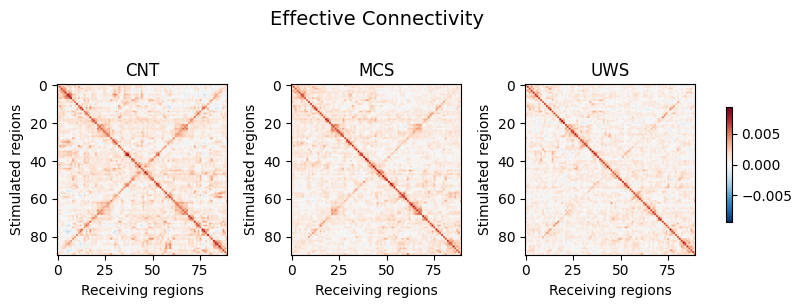

In [60]:
plot_group_matrices(
    data_dict=ECts,
    groups_id=['CNT', 'MCS', 'UWS'],
    cmap='RdBu_r',
    xlabel='Receiving regions',
    ylabel='Stimulated regions',
    suptitle='Effective Connectivity'
)

/var/folders/8j/xj5x54bs757dw9vt37nb69l40000gn/T/ipykernel_984/1535139598.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


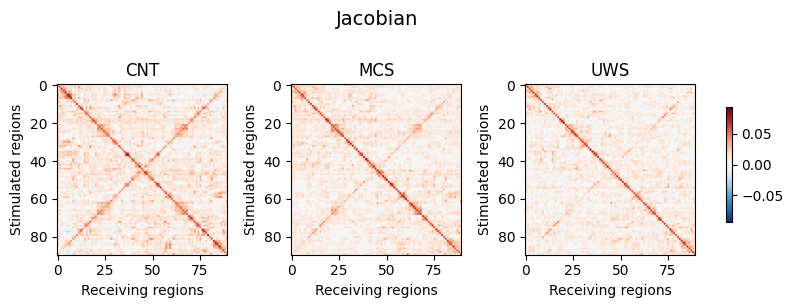

In [61]:
plot_group_matrices(
    data_dict=Jts,
    groups_id=['CNT', 'MCS', 'UWS'],
    cmap='RdBu_r',
    xlabel='Receiving regions',
    ylabel='Stimulated regions',
    suptitle='Jacobian'
)

/var/folders/8j/xj5x54bs757dw9vt37nb69l40000gn/T/ipykernel_984/1535139598.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


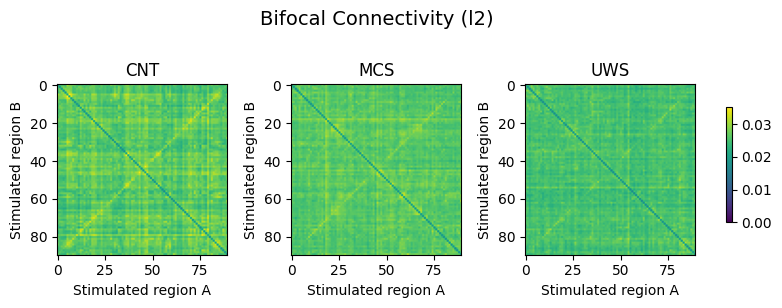

In [62]:
plot_group_matrices(
    data_dict=BECts_l2,
    groups_id=['CNT', 'MCS', 'UWS'],
    cmap='viridis',
    xlabel='Stimulated region A',
    ylabel='Stimulated region B',
    suptitle='Bifocal Connectivity (l2)',
    vmin=0
)

/var/folders/8j/xj5x54bs757dw9vt37nb69l40000gn/T/ipykernel_984/1535139598.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


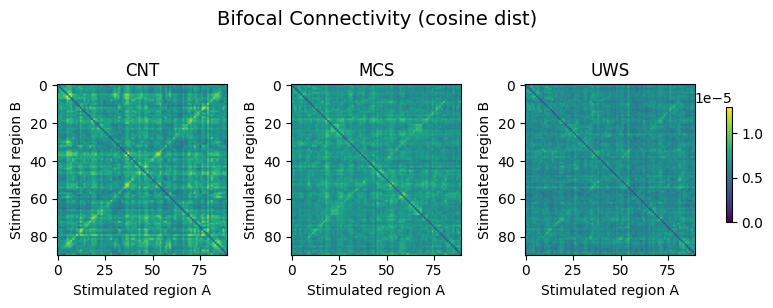

In [63]:
plot_group_matrices(
    data_dict=BECts_cos,
    groups_id=['CNT', 'MCS', 'UWS'],
    cmap='viridis',
    xlabel='Stimulated region A',
    ylabel='Stimulated region B',
    suptitle='Bifocal Connectivity (cosine dist)',
    vmin=0
)

### Example time evolution

/var/folders/8j/xj5x54bs757dw9vt37nb69l40000gn/T/ipykernel_984/203238705.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


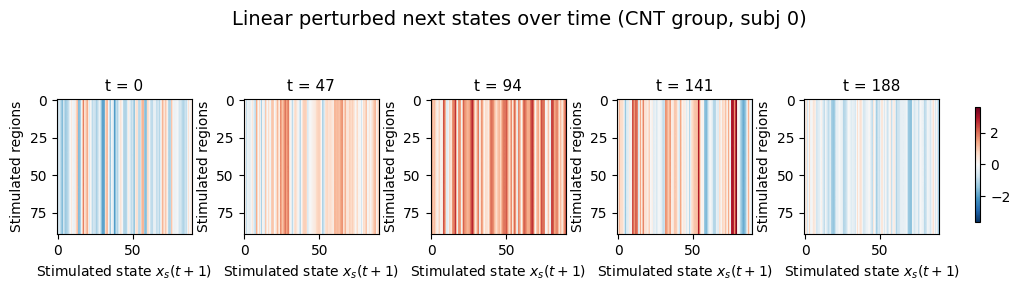

In [64]:
plot_time_evolution(
    data_dict=Effect_l_tp1,
    group=list(Effect_l_tp1.keys())[0],  # first group
    subject=0,                           # first subject
    cmap="RdBu_r",
    suptitle="Linear perturbed next states over time (CNT group, subj 0)",
    xlabel=r"Stimulated state $x_s(t+1)$",
    ylabel="Stimulated regions"
)


/var/folders/8j/xj5x54bs757dw9vt37nb69l40000gn/T/ipykernel_984/203238705.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


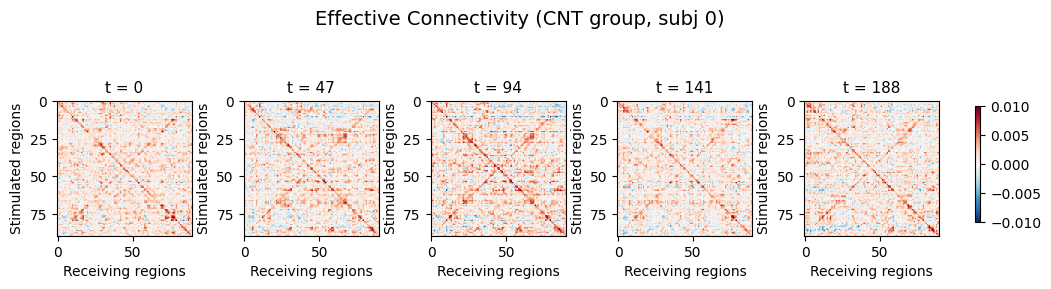

In [65]:
plot_time_evolution(
    data_dict=ECts,
    group=list(ECts.keys())[0],  # first group
    subject=0,                           # first subject
    cmap='RdBu_r',
    xlabel='Receiving regions',
    ylabel='Stimulated regions',
    suptitle='Effective Connectivity (CNT group, subj 0)',
    vmin=-0.01,vmax=0.01
)


/var/folders/8j/xj5x54bs757dw9vt37nb69l40000gn/T/ipykernel_984/203238705.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


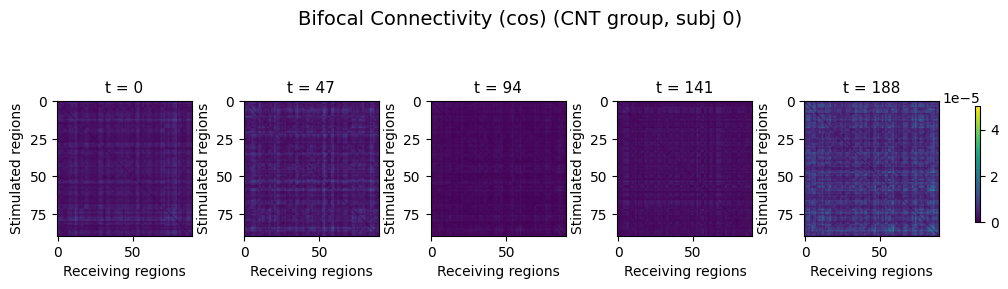

In [66]:
plot_time_evolution(
    data_dict=BECts_cos,
    group=list(BECts_cos.keys())[0],  # first group
    subject=0,                           # first subject
    cmap='viridis',
    xlabel='Receiving regions',
    ylabel='Stimulated regions',
    suptitle='Bifocal Connectivity (cos) (CNT group, subj 0)',
    vmin=0,vmax=0.00005
)


# Group Differences

### Effective connectivity

In [69]:
# ======================================================================
# For each group (g) and subject (isu):
# Compute a scalar summary of the Effective Connectivity (EC) matrix.
#
# Each ECs_sim[g][isu] is an (N × N) matrix of directed connectivity
# values obtained from perturbation-based analysis.
#
# Here, we extract only the upper-triangular part (i<j) to avoid
# duplicating symmetric connections and then compute the mean EC value
# across all directed edges.
#
# Result:
#   Mean_EC_sim[g][isu] → average EC strength for that subject.
# This can be used to compare overall coupling magnitude across groups.
# ======================================================================

Mean_EC_sim = {}
for g in groups_id:
    Mean_EC_sim[g] = {}
    for isu in range(len(groups[g])):
        # Extract the subject’s EC matrix
        ec_mat = np.mean(ECts[g][isu],axis=0)

        # Compute mean EC strength across all edges
        Mean_EC_sim[g][isu] = np.mean(ec_mat)

        # --- Alternative ideas (commented out below) ---
        # Option 1: count negative connections
        # Mean_EC_sim[g][isu] = np.sum(np.where(ec < 0, 1, 0))
        #
        # Option 2: normalize by total number of negative edges
        # Mean_EC_sim[g][isu] = np.sum(np.where(ec < 0, 1, 0)) / len(ec)

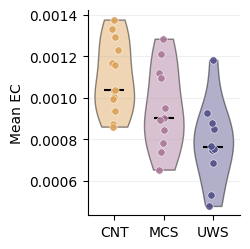

In [70]:
fig, ax = plt.subplots(figsize=(2.6, 2.6))

positions = np.arange(1, len(groups_id)+1)

data = {g: np.asarray(list(Mean_EC_sim[g].values())) for g in groups_id}

vp = ax.violinplot([data[g] for g in groups_id],
                   positions=positions,
                   showmeans=False, showmedians=True, showextrema=False,
                   widths=0.8)

# Color the violins
for i, b in enumerate(vp['bodies']):
    g = groups_id[i]
    b.set_facecolor(cols[g])
    b.set_edgecolor('k')
    b.set_alpha(0.45)

# Median lines style
vp['cmedians'].set_color('k')
vp['cmedians'].set_linewidth(1.5)

# Scatter/jitter subject dots
rng = np.random.default_rng(7)
for i, g in enumerate(groups_id):
    y = data[g]
    x = rng.normal(loc=positions[i], scale=0.05, size=len(y))   # jitter
    ax.scatter(x, y, s=28, alpha=0.9, edgecolor='white', linewidth=0.4,
               color=cols[g], zorder=3)

# Cosmetic tweaks
ax.set_xticks(positions)
ax.set_xticklabels(groups_id)
ax.set_ylabel("Mean EC")
#ax.set_ylim(0.7, 1.0)            # adjust if you want full range
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
#plt.savefig("corr_violin.png", dpi=300, transparent=True)
plt.show()

### Bifocal Effective connectivity

In [79]:
Mean_BEC_sim={}
for g in groups_id:
    Mean_BEC_sim[g]={}
    for isu in range(len(groups[g])):
        ec_mat=np.mean(BECts_l2[g][isu],axis=0)
        ec = ec_mat[np.triu_indices(N, k=1)]
        Mean_BEC_sim[g][isu]=np.mean(ec)

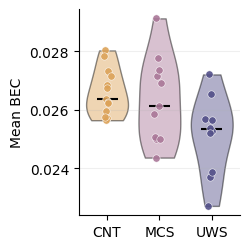

In [80]:
data = {g: np.asarray(list(Mean_BEC_sim[g].values())) for g in groups_id}

# ----- plot -----
fig, ax = plt.subplots(figsize=(2.6, 2.6))

positions = np.arange(1, len(groups_id)+1)

vp = ax.violinplot([data[g] for g in groups_id],
                   positions=positions,
                   showmeans=False, showmedians=True, showextrema=False,
                   widths=0.8)

# Color the violins
for i, b in enumerate(vp['bodies']):
    g = groups_id[i]
    b.set_facecolor(cols[g])
    b.set_edgecolor('k')
    b.set_alpha(0.45)

# Median lines style
vp['cmedians'].set_color('k')
vp['cmedians'].set_linewidth(1.5)

# Scatter/jitter subject dots
rng = np.random.default_rng(7)
for i, g in enumerate(groups_id):
    y = data[g]
    x = rng.normal(loc=positions[i], scale=0.05, size=len(y))   # jitter
    ax.scatter(x, y, s=28, alpha=0.9, edgecolor='white', linewidth=0.4,
               color=cols[g], zorder=3)

# Cosmetic tweaks
ax.set_xticks(positions)
ax.set_xticklabels(groups_id)
ax.set_ylabel("Mean BEC")
#ax.set_ylim(0.7, 1.0)            # adjust if you want full range
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', alpha=0.2)

plt.tight_layout()
#plt.savefig("corr_violin.png", dpi=300, transparent=True)
plt.show()

# Groups Classification

# OLD STUFF TO re-DO

In [2]:
# def tri_to_mat(triup):
#     n = int((1 + np.sqrt(1 + 8*len(triup))) / 2)
#     mat=np.zeros((n,n))
#     mat[np.triu_indices(n,1)]=triup
#     return mat+mat.T

In [56]:
# # ======================================================================
# # For each group (g) and subject (isu):
# # Compute a scalar index of "fluidity" of effective connectivity (EC)
# # dynamics, based on the temporal variability of EC(t).
# #
# # Recall:
# #   dECs_sim[g][isu] → (T-S, T-S) matrix of correlations between EC(t)
# #                       patterns at different times.
# #                       Each entry (i,j) indicates how similar the EC
# #                       structure is between time windows i and j.
# #
# # Here, we take the upper triangular part of dECs_sim[g][isu] (to avoid
# # duplicate correlations and self-comparisons) and compute its variance.
# #
# # Interpretation:
# #   - High variance  → EC(t) patterns fluctuate strongly over time,
# #                      indicating *high fluidity* of effective connectivity.
# #   - Low variance   → EC(t) remains relatively stable, i.e., more rigid
# #                      or stationary dynamics.
# #
# # Result:
# #   Fluidity_dEC_sim[g][isu] → scalar summary of how variable the dynamic
# #                              EC correlations are across time for each subject.
# # ======================================================================

# Fluidity_dEC_sim = {}
# for g in groups_id:
#     Fluidity_dEC_sim[g] = {}
#     for isu in range(len(groups[g])):
#         # Compute variance of the upper-triangular (unique) elements of
#         # the time×time correlation matrix of EC(t)
#         Fluidity_dEC_sim[g][isu] = np.var(
#             dECs_sim[g][isu][np.triu_indices(T - S, k=1)]
#         )

In [81]:
# fig, ax = plt.subplots(figsize=(2.6, 2.6))

# positions = np.arange(1, len(groups_id)+1)

# data = {g: np.asarray(list(Fluidity_dEC_sim[g].values())) for g in groups_id}

# vp = ax.violinplot([data[g] for g in groups_id],
#                    positions=positions,
#                    showmeans=False, showmedians=True, showextrema=False,
#                    widths=0.8)

# # Color the violins
# for i, b in enumerate(vp['bodies']):
#     g = groups_id[i]
#     b.set_facecolor(cols[g])
#     b.set_edgecolor('k')
#     b.set_alpha(0.45)

# # Median lines style
# vp['cmedians'].set_color('k')
# vp['cmedians'].set_linewidth(1.5)

# # Scatter/jitter subject dots
# rng = np.random.default_rng(7)
# for i, g in enumerate(groups_id):
#     y = data[g]
#     x = rng.normal(loc=positions[i], scale=0.05, size=len(y))   # jitter
#     ax.scatter(x, y, s=28, alpha=0.9, edgecolor='white', linewidth=0.4,
#                color=cols[g], zorder=3)

# # Cosmetic tweaks
# ax.set_xticks(positions)
# ax.set_xticklabels(groups_id)
# ax.set_ylabel("var dEC")
# #ax.set_ylim(0.7, 1.0)            # adjust if you want full range
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.grid(axis='y', alpha=0.2)

# plt.tight_layout()
# #plt.savefig("corr_violin.png", dpi=300, transparent=True)
# plt.show()

In [70]:
# Fluidity_dBEC_sim={}
# for g in groups_id:
#     Fluidity_dBEC_sim[g]={}
#     for isu in range(len(groups[g])):
#         Fluidity_dBEC_sim[g][isu]=np.var(dECs_sim[g][isu][np.triu_indices(T-S, k=1)])

In [82]:
# data = {g: np.asarray(list(Fluidity_dEC_sim[g].values())) for g in groups_id}

# # ----- plot -----
# fig, ax = plt.subplots(figsize=(2.6, 2.6))

# positions = np.arange(1, len(groups_id)+1)

# vp = ax.violinplot([data[g] for g in groups_id],
#                    positions=positions,
#                    showmeans=False, showmedians=True, showextrema=False,
#                    widths=0.8)

# # Color the violins
# for i, b in enumerate(vp['bodies']):
#     g = groups_id[i]
#     b.set_facecolor(cols[g])
#     b.set_edgecolor('k')
#     b.set_alpha(0.45)

# # Median lines style
# vp['cmedians'].set_color('k')
# vp['cmedians'].set_linewidth(1.5)

# # Scatter/jitter subject dots
# rng = np.random.default_rng(7)
# for i, g in enumerate(groups_id):
#     y = data[g]
#     x = rng.normal(loc=positions[i], scale=0.05, size=len(y))   # jitter
#     ax.scatter(x, y, s=28, alpha=0.9, edgecolor='white', linewidth=0.4,
#                color=cols[g], zorder=3)

# # Cosmetic tweaks
# ax.set_xticks(positions)
# ax.set_xticklabels(groups_id)
# ax.set_ylabel("var dEC")
# #ax.set_ylim(0.7, 1.0)            # adjust if you want full range
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.grid(axis='y', alpha=0.2)

# plt.tight_layout()
# #plt.savefig("corr_violin.png", dpi=300, transparent=True)
# plt.show()